# Caso de estudio: Reconstrucción del campo de flujo en una cavidad cuadrada

**Profesores**: Dr. Ing. Benjamin A. TOURN - Ing. Carlos G. MASSOBRIO

**Cohorte**: B32025

**Grupo**: N°2

**Alumno**: Maximiliano Torti

## EDP

**Ecuaciones de Navier-Stokes incompresibles**

$$(\mathbf{u}\cdot\nabla)\mathbf{u} = -\nabla p + 1/R_e \nabla^2 \mathbf{u}, \text{ en } \Omega $$
$$\nabla \mathbf{u} = 0, \text{ en } \Omega $$

## TP N°1: Puntos de colocacion

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib import cm
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from pyDOE import lhs
from scipy.interpolate import LinearNDInterpolator

In [2]:
pressure_raw_data = scipy.io.loadmat('./Re-100/pressure.mat')
velocity_raw_data = scipy.io.loadmat('./Re-100/velocity.mat')

In [3]:
pressure_raw_data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Apr  5 20:31:06 2023',
 '__version__': '1.0',
 '__globals__': [],
 'x': array([[0.   , 0.01 , 0.02 , ..., 0.975, 0.985, 0.995]]),
 'y': array([[0.   , 0.   , 0.   , ..., 0.995, 0.995, 0.995]]),
 'z': array([[0., 0., 0., ..., 0., 0., 0.]]),
 'p': array([[0.00000000e+00, 1.62864847e-05, 1.31113620e-05, ...,
         1.05833522e+00, 1.66906380e+00, 3.40199098e+00]])}

In [4]:
velocity_raw_data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Apr  5 20:33:39 2023',
 '__version__': '1.0',
 '__globals__': [],
 'x': array([[0.   , 0.01 , 0.02 , ..., 0.975, 0.985, 0.995]]),
 'y': array([[0.   , 0.   , 0.   , ..., 0.995, 0.995, 0.995]]),
 'z': array([[0., 0., 0., ..., 0., 0., 0.]]),
 'u': array([[0.        , 0.        , 0.        , ..., 0.65946941, 0.49345089,
         0.17337734]]),
 'v': array([[ 0.        ,  0.        ,  0.        , ..., -0.03262434,
         -0.06381343, -0.15660411]]),
 'w': array([[0., 0., 0., ..., 0., 0., 0.]])}

### 1. Xpde y Xbc

In [5]:
# n_pde debe ser = n^2 para grilla regular
n_pde = 1024
n_bc= 100

x_lb = 0
x_ub = 1
y_lb = 0
y_ub = 1

#### Grilla regular

In [6]:
def get_xy_pde_mesh(x_bounds, y_bounds, n):
    x_step = (x_bounds[1]-x_bounds[0])/(np.sqrt(n) + 1)
    y_step = (y_bounds[1]-y_bounds[0])/(np.sqrt(n) + 1)
    x = np.arange(x_bounds[0] + x_step, x_bounds[1], x_step)
    y = np.arange(y_bounds[0]  + y_step, y_bounds[1], y_step)
    return np.array([[x_i, y_i] for x_i in x for y_i in y])

xy_pde_mesh = get_xy_pde_mesh([x_lb, x_ub], [y_lb, y_ub], n_pde)

In [7]:
def get_xy_bc_mesh(x_bounds, y_bounds, n):
    x_step = (x_bounds[1]-x_bounds[0])/(n / 4)
    y_step = (y_bounds[1]-y_bounds[0])/(n / 4)
    l1 = np.array([[x_i, y_bounds[0]] for x_i in np.arange(x_bounds[0], x_bounds[1], x_step)])
    l2 = np.array([[x_bounds[1], y_i] for y_i in np.arange(y_bounds[0], y_bounds[1], y_step)])
    l3 = np.array([[x_i, y_bounds[1]] for x_i in np.arange(x_bounds[1], x_bounds[0], -x_step)])
    l4 = np.array([[x_bounds[0], y_i] for y_i in np.arange(y_bounds[1], y_bounds[0], -y_step)])
    return np.concatenate([l1,l2,l3,l4], axis=0)

xy_bc_mesh = get_xy_bc_mesh([x_lb, x_ub], [y_lb, y_ub], n_bc)

#### Muestreo aleatorio

In [8]:
def get_xy_pde_random(x_bounds, y_bounds, n):
    x = np.random.uniform(np.nextafter(x_bounds[0], x_bounds[1]), x_bounds[1], n)
    y = np.random.uniform(np.nextafter(y_bounds[0], y_bounds[1]), y_bounds[1], n)
    return np.array([[x[i], y[i]] for i in range(n)])

xy_pde_random = get_xy_pde_random([x_lb, x_ub], [y_lb, y_ub], n_pde)

In [9]:
def get_xy_bc_random(x_bounds, y_bounds, n):
    xy = []
    for i in range(n):    
        side = random.choice(['top', 'right', 'bottom', 'left'])
        if side == 'top':
            xy.append([x_bounds[1], np.random.uniform(y_bounds[0], y_bounds[1], 1)[0]])
        elif side == 'right':
            xy.append([np.random.uniform(x_bounds[0], x_bounds[1], 1)[0], y_bounds[1]])
        elif side == 'bottom':
            xy.append([x_bounds[0], np.random.uniform(y_bounds[0], y_bounds[1], 1)[0]])
        else:  # side == 'left'
            xy.append([np.random.uniform(x_bounds[0], x_bounds[1], 1)[0], y_bounds[0]])
    return np.array(xy)

xy_bc_random = get_xy_bc_random([x_lb, x_ub], [y_lb, y_ub], n_bc)

### 2. Graficar puntos de colocación

#### Grilla regular

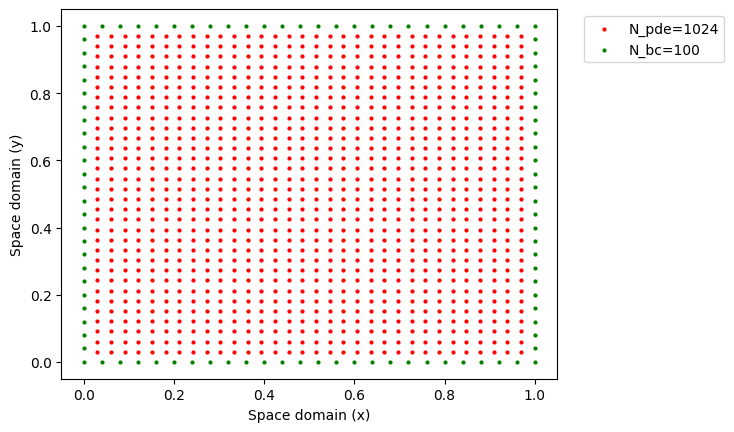

In [10]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xy_pde_mesh[:,0], xy_pde_mesh[:,1], s=4, c='r', label=f'N_pde={len(xy_pde_mesh)}')
ax.scatter(xy_bc_mesh[:,0], xy_bc_mesh[:,1], s=4, c='g', label=f'N_bc={len(xy_bc_mesh)}')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.legend()
plt.xlabel('Space domain (x)')
plt.ylabel('Space domain (y)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

#### Muestreo aleatorio

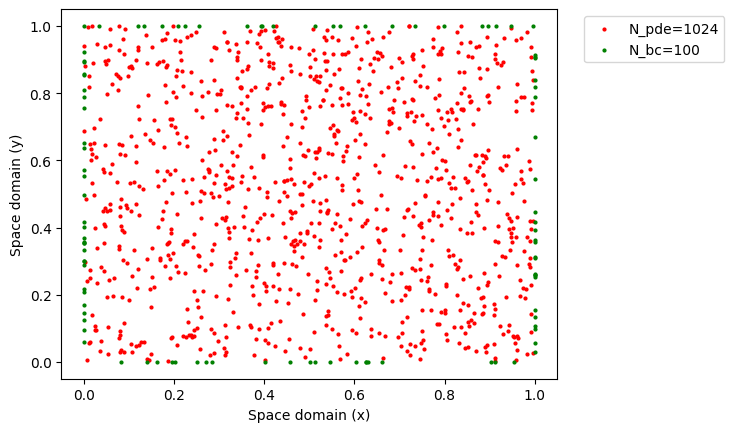

In [11]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xy_pde_random[:,0], xy_pde_random[:,1], s=4, c='r', label=f'N_pde={len(xy_pde_mesh)}')
ax.scatter(xy_bc_random[:,0], xy_bc_random[:,1], s=4, c='g', label=f'N_bc={len(xy_bc_mesh)}')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.legend()
plt.xlabel('Space domain (x)')
plt.ylabel('Space domain (y)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

### 3. Datos rotulados

In [12]:
n_data = 10

In [13]:
def get_ds_data(pressure_ds, velocity_ds, n):
    idxs = [random.randrange(0, len(pressure_raw_data['x'][0])) for _ in range(n)]
    xy = []
    labels = []
    for idx in idxs:
        assert pressure_ds['x'][0][idx] == velocity_ds['x'][0][idx]
        assert pressure_ds['y'][0][idx] == velocity_ds['y'][0][idx]
        xy.append([pressure_ds['x'][0][idx], pressure_ds['y'][0][idx]])
        labels.append([velocity_ds['u'][0][idx], velocity_ds['v'][0][idx], pressure_ds['p'][0][idx]])
    return np.array(xy), np.array(labels)

xy_data_random, labels_data_random = get_ds_data(pressure_raw_data, velocity_raw_data, n_data)

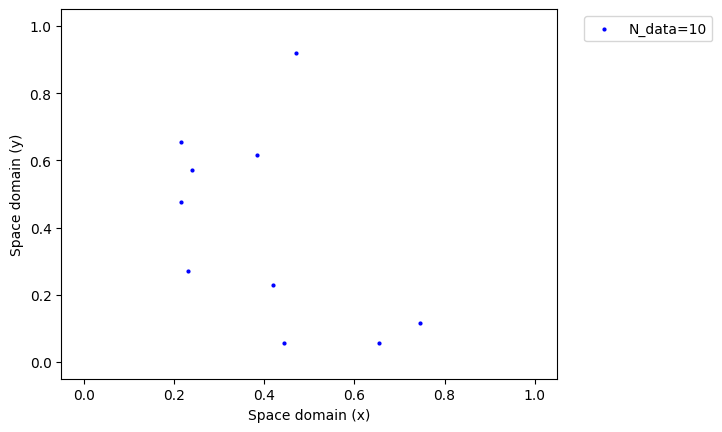

In [14]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xy_data_random[:,0], xy_data_random[:,1], s=4, c='b', label=f'N_data={len(xy_data_random)}')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.legend()
plt.xlabel('Space domain (x)')
plt.ylabel('Space domain (y)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

Este dataset de datos rotulados contiene no solamente los valores de input (x e y) del modelo sino también los valores de las etiquetas/salidas (p, u, v), por lo que constituye un caso de entrenamiento supervisado. En cambio, los datasets de puntos de colocación contienen solamente los valores de input (x e y) del modelo, por lo que se asemejaría más a un problema no supervisado, pero en realidad lo convertimos en "supervisado" a traves del uso de las EDP.

Como la estructura del dataset de datos rotulados y la de los datasets de puntos de colocación son diferentes, no podremos concatenarlos y seleccionar aleatoriamente batch que incluyan puntos de ambos al mismo tiempo. En su lugar, tendremos que entrenar el modelo de a pasos.

### 4. Para pensar

El sub-conjunto de los puntos de colocación xy_pde no debería contener puntos sobre la frontera del dominio, ya que la definición de la PDE se hace sobre el conjunto abierto del dominio (sin incluir el borde).

## TP N°2: Modelado PINN

### 1. Rutina PINN

Las ecuaciones vectoriales de Navier-Stokes incompresibles para 2D pueden ser desarrolladas como

$$ u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y}= -\frac{\partial p}{\partial x} + 1/R_e(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}), \text{ en } \Omega $$

$$ u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y}= -\frac{\partial p}{\partial y} + 1/R_e(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}), \text{ en } \Omega $$

$$\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0, \text{ en } \Omega $$

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [16]:
 class PINN_Module(nn.Module):

    def __init__(self, model_parameters):
        super(PINN_Module, self).__init__()
        self.Reynolds = model_parameters["Reynolds"]
        self.InputDimensions = model_parameters["InputDimensions"]
        self.OutputDimensions = model_parameters["OutputDimensions"]
        self.NumberOfNeurons = model_parameters["NumberOfNeurons"]
        self.NumberOfHiddenLayers = model_parameters["NumberOfHiddenLayers"]
        self.ActivationFunction = model_parameters["ActivationFunction"]
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons) for _ in range(self.NumberOfHiddenLayers - 1)])
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions)
        self.init_xavier()
        
    def init_xavier(self):
        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                m.bias.data.fill_(0)
        self.apply(init_weights)

    def forward(self, x):
        output = self.ActivationFunction(self.InputLayer(x))
        for k, l in enumerate(self.HiddenLayers):
            output = self.ActivationFunction(l(output))
        output = self.OutputLayer(output)
        return output

    def pdeResidue(self, X, output):
        # Separate output in u,v and p
        u = output[:,0:1]
        v = output[:,1:2]
        p = output[:,2:3]
        
        # Compute the derivatives of the outputs u,v and p over the inputs (x,y) using AD mechanism:
        diff_u = torch.autograd.grad(u, X, create_graph=True, grad_outputs=torch.ones_like(u))[0]
        diff_v = torch.autograd.grad(v, X, create_graph=True, grad_outputs=torch.ones_like(v))[0]
        diff_p = torch.autograd.grad(p, X, create_graph=True, grad_outputs=torch.ones_like(p))[0]
        u_x, u_y = diff_u[:, 0:1], diff_u[:, 1:2]
        v_x, v_y = diff_v[:, 0:1], diff_v[:, 1:2]
        p_x, p_y = diff_p[:, 0:1], diff_p[:, 1:2]

        # Compute the second derivative of the outputs u and v over the inputs (x,y) using AD mechanism:
        u_xx = torch.autograd.grad(u_x, X, create_graph=True, grad_outputs=torch.ones_like(u_x))[0][:, 0:1]
        u_yy = torch.autograd.grad(u_y, X, create_graph=True, grad_outputs=torch.ones_like(u_y))[0][:, 1:2]
        v_xx = torch.autograd.grad(v_x, X, create_graph=True, grad_outputs=torch.ones_like(v_x))[0][:, 0:1]
        v_yy = torch.autograd.grad(v_y, X, create_graph=True, grad_outputs=torch.ones_like(v_y))[0][:, 1:2]
        
        # Compute residues
        residue_continuity = u_x + v_y
        residue_momentum_x = u * u_x + v * u_y + p_x - (1/self.Reynolds) * (u_xx + u_yy)
        residue_momentum_y = u * v_x + v * v_y + p_y - (1/self.Reynolds) * (v_xx + v_yy)
        return residue_continuity, residue_momentum_x, residue_momentum_y

    def bcUVResidue(self, X, output):
        # Separate u and v from the output
        u = output[:,0:1]
        v = output[:,1:2]
        # Calculate true bc values 
        u_bc = (X[:,1:2] == 1) * 1.0 # u = 1 only at upper y bound, else 0
        residue_u = u - u_bc
        residue_v = v # v = 0 on all border
        return residue_u, residue_v

    def bcPResidue(self, X, output):
        # Separate p from the output
        p = output[:,2:3]
        residue_p = p # p = 0 on the origin
        return residue_p

### 2. Resolver PINN

In [17]:
model_parameters = {
    "Reynolds": 100,
    "InputDimensions": 2,
    "OutputDimensions": 3,
    "NumberOfNeurons": 100,
    "NumberOfHiddenLayers": 4,
    "ActivationFunction": nn.GELU()
}

In [47]:
model = PINN_Module(model_parameters).to(device)
epochs = 10_000
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Initialization of data structures
xy_pde_random = get_xy_pde_random([x_lb, x_ub], [y_lb, y_ub], 10_000)
X_pde = torch.tensor(xy_pde_random, requires_grad = True).float().to(device)
xy_bc_random = get_xy_bc_random([x_lb, x_ub], [y_lb, y_ub], 1_000)
X_bc = torch.tensor(xy_bc_random).float().to(device)
X_bc_0 = torch.tensor([[0, 0]]).float().to(device)
xy_data_random, labels_data_random = get_ds_data(pressure_raw_data, velocity_raw_data, 10)
X_data = torch.tensor(xy_data_random).float().to(device)
Y_data = torch.tensor(labels_data_random).float().to(device)

loss_train = {'Overall' : [], 
              'PDE': [], 'PDE_Continuity': [], 'PDE_MomentumX': [], 'PDE_MomentumY': [], \
              'BC': [], 'BC_U': [], 'BC_V': [], 'BC_P': [], \
              'Data': []}

best_val_loss = float('inf')
best_model_state = None

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()

     # PDE
    output_pde = model(X_pde)
    residue_continuity, residue_momentum_x, residue_momentum_y  = model.pdeResidue(X_pde, output_pde)
    loss_pde_continuity = loss_fn(residue_continuity, torch.zeros_like(residue_continuity))
    loss_pde_momentum_x = loss_fn(residue_momentum_x, torch.zeros_like(residue_momentum_x))
    loss_pde_momentum_y = loss_fn(residue_momentum_y, torch.zeros_like(residue_momentum_y))
    loss_pde = (loss_pde_continuity + loss_pde_momentum_x + loss_pde_momentum_y) / 3
    
    # BC
    output_bc = model(X_bc)
    residue_u, residue_v = model.bcUVResidue(X_bc, output_bc)
    loss_bc_u = loss_fn(residue_u, torch.zeros_like(residue_u))
    loss_bc_v = loss_fn(residue_v, torch.zeros_like(residue_v))
    output_bc_0 = model(X_bc_0)
    residue_p = model.bcPResidue(X_bc_0, output_bc_0)
    loss_bc_p = loss_fn(residue_p, torch.zeros_like(residue_p))
    loss_bc = loss_bc_u * 10 + loss_bc_v * 10 + loss_bc_p * 100
    
    #Loss data
    y_hat_data = model(X_data)
    loss_data = loss_fn(y_hat_data, Y_data)

    # Loss, backpropagation and gradient descent
    loss_overall = loss_pde + loss_bc + loss_data
    loss_overall.backward()
    optimizer.step()

    # Checkpoint best model
    if loss_overall.item() < best_val_loss:
        best_val_loss = loss_overall.item()
        best_model_state = model.state_dict()

    # Log
    loss_train['Overall'].append(loss_overall.item())
    loss_train['PDE'].append(loss_pde.item())
    loss_train['PDE_Continuity'].append(loss_pde_continuity.item())
    loss_train['PDE_MomentumX'].append(loss_pde_momentum_x.item())
    loss_train['PDE_MomentumY'].append(loss_pde_momentum_y.item())
    loss_train['BC'].append(loss_bc.item())
    loss_train['BC_U'].append(loss_bc_u.item())
    loss_train['BC_V'].append(loss_bc_v.item())
    loss_train['BC_P'].append(loss_bc_p.item())
    loss_train['Data'].append(loss_data.item())
    if (epoch+1) % (epochs / 20) == 0:
        tqdm.write(f"Epoch {epoch+1}/{epochs} - Loss Overall: {loss_overall.item():.4e}, "
                   f"PDE: {loss_pde.item():.4e}, BC: {loss_bc.item():.4e}, Data: {loss_data.item():.4e}")
        
model.load_state_dict(best_model_state)

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 500/10000 - Loss Overall: 1.7947e-01, PDE: 9.2375e-03, BC: 1.5036e-01, Data: 1.9865e-02
Epoch 1000/10000 - Loss Overall: 1.3143e-01, PDE: 1.0198e-02, BC: 1.0261e-01, Data: 1.8622e-02
Epoch 1500/10000 - Loss Overall: 1.2051e-01, PDE: 1.2759e-02, BC: 9.0009e-02, Data: 1.7744e-02
Epoch 2000/10000 - Loss Overall: 1.1183e-01, PDE: 1.6600e-02, BC: 7.9925e-02, Data: 1.5309e-02
Epoch 2500/10000 - Loss Overall: 9.6828e-02, PDE: 1.2346e-02, BC: 7.2848e-02, Data: 1.1634e-02
Epoch 3000/10000 - Loss Overall: 7.5433e-02, PDE: 1.2433e-02, BC: 5.6510e-02, Data: 6.4896e-03
Epoch 3500/10000 - Loss Overall: 6.4349e-02, PDE: 1.3041e-02, BC: 4.7880e-02, Data: 3.4279e-03
Epoch 4000/10000 - Loss Overall: 5.5528e-02, PDE: 1.2037e-02, BC: 4.1911e-02, Data: 1.5807e-03
Epoch 4500/10000 - Loss Overall: 6.3317e-02, PDE: 1.4446e-02, BC: 4.7375e-02, Data: 1.4964e-03
Epoch 5000/10000 - Loss Overall: 4.0755e-02, PDE: 9.8140e-03, BC: 3.0430e-02, Data: 5.1087e-04
Epoch 5500/10000 - Loss Overall: 3.5460e-02, PDE: 8

<All keys matched successfully>

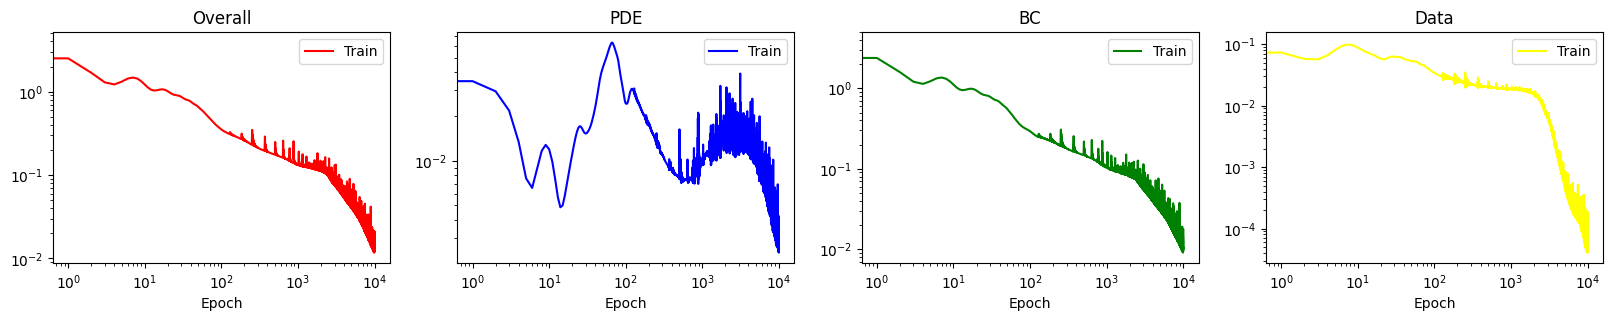

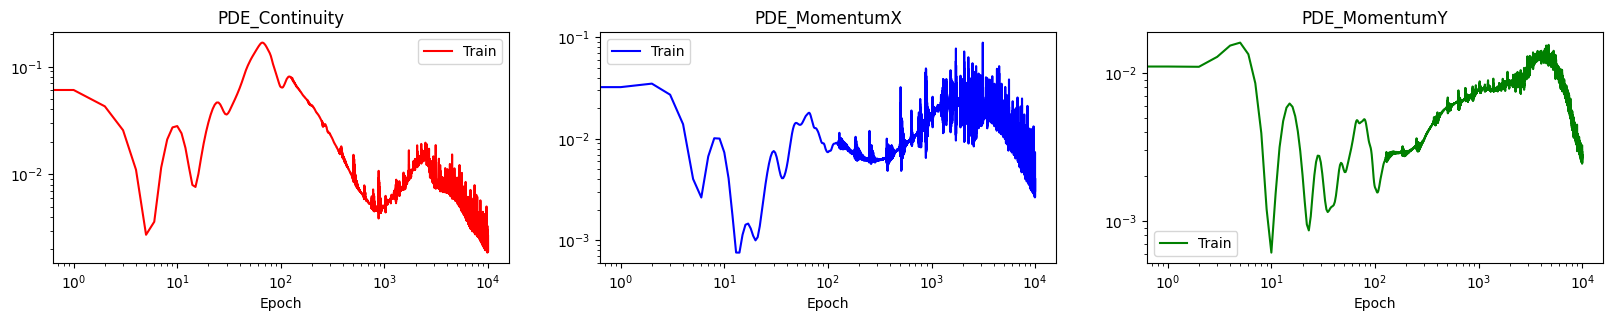

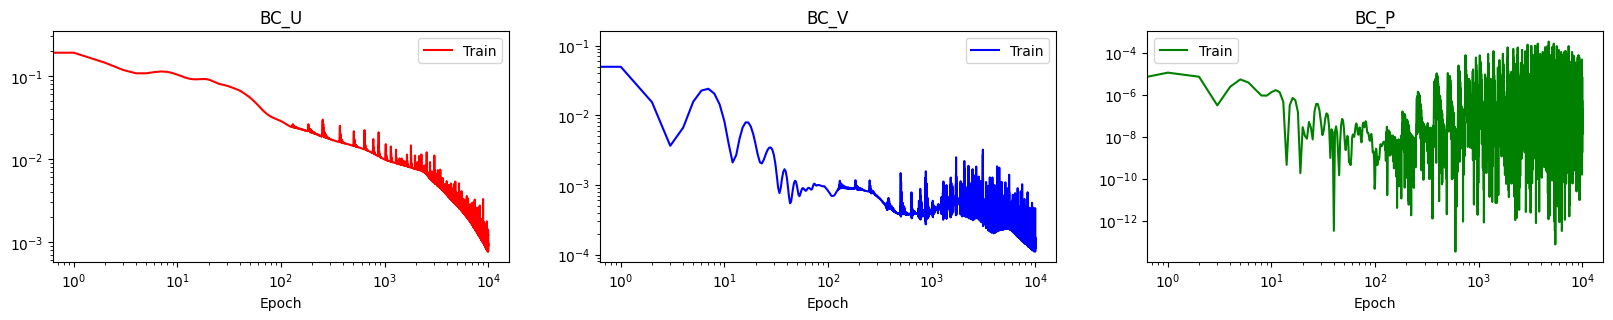

In [48]:
# Evolution of the loss function
colors = ['red', 'blue', 'green', 'yellow']
# Overall
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
for i, loss_type in enumerate(['Overall', 'PDE', 'BC', 'Data']):
    epoch_train = np.arange(0, len(loss_train[loss_type]))
    ax[i].loglog(epoch_train, loss_train[loss_type], color=colors[i], label='Train')
    ax[i].set_xlabel('Epoch')
    ax[i].set_title(loss_type)
    ax[i].legend()
plt.show()
    
# PDE
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
for i, loss_type in enumerate(['PDE_Continuity', 'PDE_MomentumX', 'PDE_MomentumY']):
    epoch_train = np.arange(0, len(loss_train[loss_type]))
    ax[i].loglog(epoch_train, loss_train[loss_type], color=colors[i], label='Train')
    ax[i].set_xlabel('Epoch')
    ax[i].set_title(loss_type)
    ax[i].legend()
plt.show()

# BC
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
for i, loss_type in enumerate(['BC_U', 'BC_V', 'BC_P']):
    epoch_train = np.arange(0, len(loss_train[loss_type]))
    ax[i].loglog(epoch_train, loss_train[loss_type], color=colors[i], label='Train')
    ax[i].set_xlabel('Epoch')
    ax[i].set_title(loss_type)
    ax[i].legend()
plt.show()

In [49]:
torch.save(model.state_dict(), "./model.pt")

### 3. Calculo de error

In [50]:
xy_data_all = np.concatenate([pressure_raw_data['x'][0][:,np.newaxis], pressure_raw_data['y'][0][:,np.newaxis]], axis=1)
labels_data_all = np.concatenate([velocity_raw_data['u'][0][:,np.newaxis],velocity_raw_data['v'][0][:,np.newaxis],
                                 pressure_raw_data['p'][0][:,np.newaxis]], axis=1)

In [51]:
model.train(False)
with torch.no_grad():
    X_data = torch.tensor(xy_data_all).float().to(device)
    output_data = model(X_data).cpu().numpy()

In [52]:
mse_u = mean_squared_error(output_data[:,0], labels_data_all[:,0])
mse_v = mean_squared_error(output_data[:,1], labels_data_all[:,1])
mse_p = mean_squared_error(output_data[:,2], labels_data_all[:,2])
print(f"Normal 2  del error (ECM) en u: {mse_u}, v: {mse_v}, p: {mse_p}")

Normal 2  del error (ECM) en u: 0.0002477252066810599, v: 0.00020755137828114254, p: 0.0027589995664793554


### 4. Gráficas

#### Campos de predicción de velocidades y presión

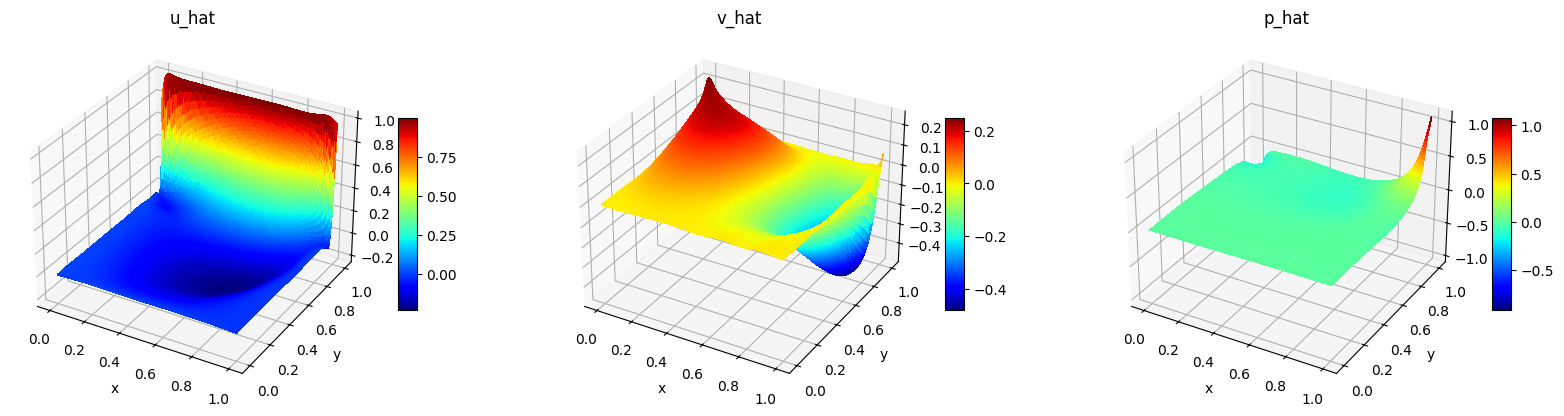

In [53]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5), subplot_kw=dict(projection='3d'))
# u graph
ax = axs[0]
surf = ax.plot_trisurf(xy_data_all[:,0], xy_data_all[:,1], output_data[:,0], cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('u_hat')

# v graph
ax = axs[1]
surf = ax.plot_trisurf(xy_data_all[:,0], xy_data_all[:,1], output_data[:,1], cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('v_hat')

# p graph
ax = axs[2]
surf = ax.plot_trisurf(xy_data_all[:,0], xy_data_all[:,1], output_data[:,2], cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('p_hat')
plt.show()

#### Campos reales de velocidades y presión

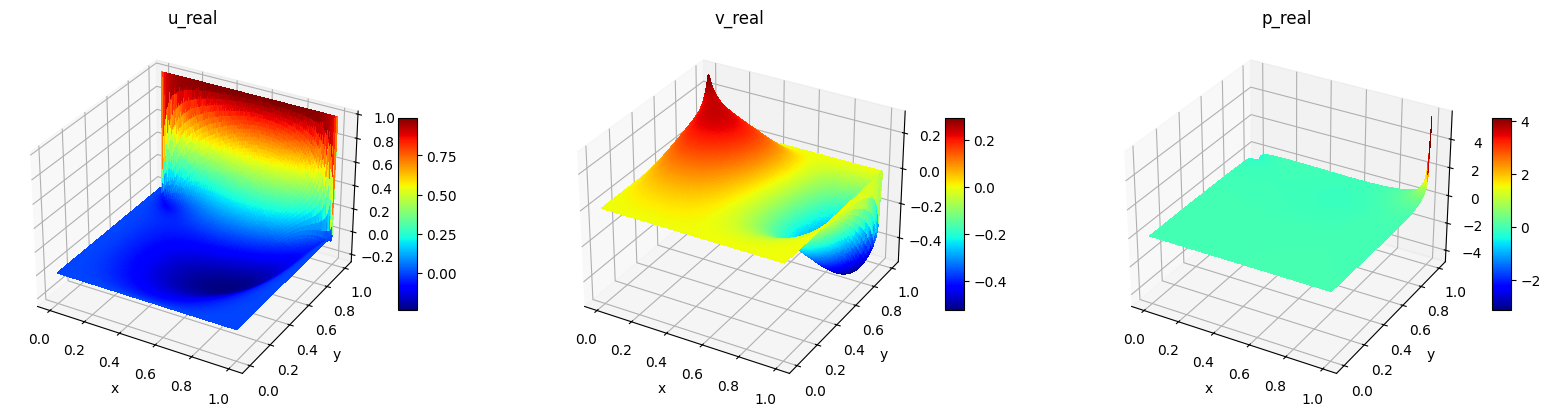

In [54]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5), subplot_kw=dict(projection='3d'))
# u graph
ax = axs[0]
surf = ax.plot_trisurf(xy_data_all[:,0], xy_data_all[:,1], labels_data_all[:,0], cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('u_real')

# v graph
ax = axs[1]
surf = ax.plot_trisurf(xy_data_all[:,0], xy_data_all[:,1], labels_data_all[:,1], cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('v_real')

# p graph
ax = axs[2]
surf = ax.plot_trisurf(xy_data_all[:,0], xy_data_all[:,1], labels_data_all[:,2], cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('p_real')
plt.show()

#### Gráficas error absoluto

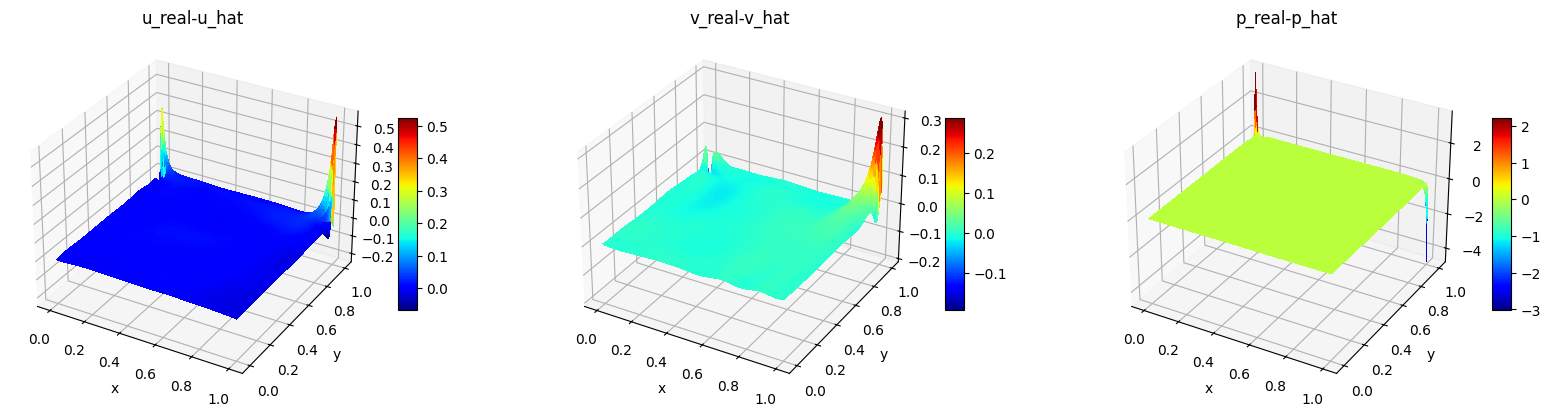

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5), subplot_kw=dict(projection='3d'))
# u graph
ax = axs[0]
surf = ax.plot_trisurf(xy_data_all[:,0], xy_data_all[:,1], output_data[:,0]-labels_data_all[:,0], cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('u_real-u_hat')

# v graph
ax = axs[1]
surf = ax.plot_trisurf(xy_data_all[:,0], xy_data_all[:,1], output_data[:,1]-labels_data_all[:,1], cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('v_real-v_hat')

# p graph
ax = axs[2]
surf = ax.plot_trisurf(xy_data_all[:,0], xy_data_all[:,1], output_data[:,2]-labels_data_all[:,2], cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('p_real-p_hat')
plt.show()

#### Gráficas perfiles

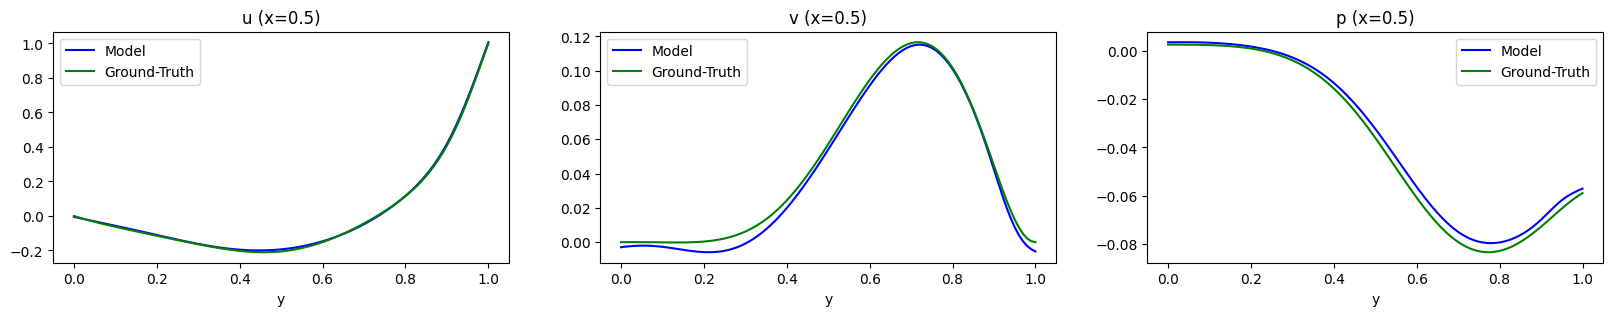

In [56]:
# Grafica sobre x=0.5
mask_x05 = np.where(xy_data_all[:, 0] == 0.5)
xy_data_x05 = xy_data_all[mask_x05]
labels_data_x05 = labels_data_all[mask_x05]

model.train(False)
with torch.no_grad():
    X_data = torch.tensor(xy_data_x05).float().to(device)
    output_data = model(X_data).cpu().numpy()

fig, ax = plt.subplots(1, 3, figsize=(20, 3))
for i, title in enumerate(['u', 'v', 'p']):
    ax[i].plot(xy_data_x05[:,1], output_data[:,i], color='blue', label='Model')
    ax[i].plot(xy_data_x05[:,1], labels_data_x05[:,i], color='green', label='Ground-Truth')
    ax[i].set_xlabel('y')
    ax[i].set_title(f"{title} (x=0.5)")
    ax[i].legend()
plt.show()

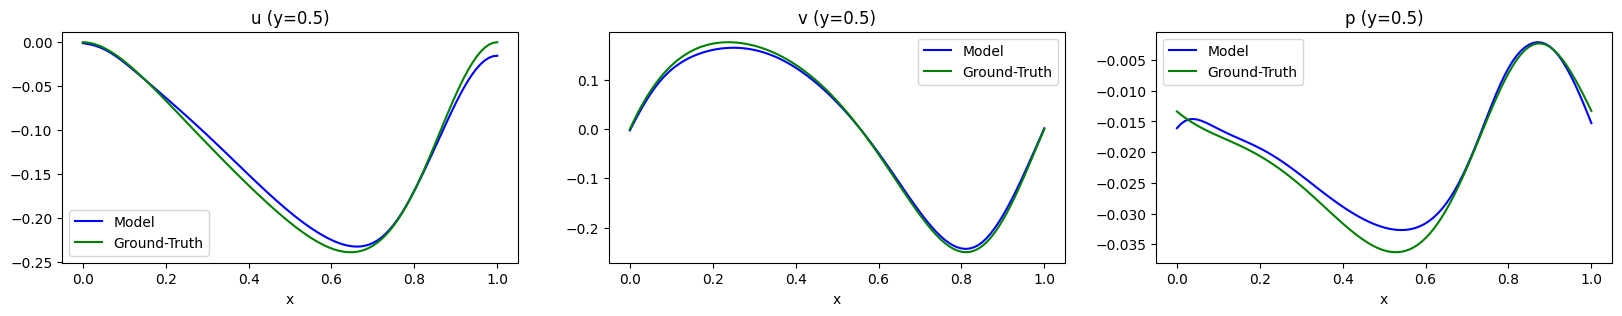

In [57]:
# Grafica sobre y=0.5
mask_y05 = np.where(xy_data_all[:, 1] == 0.5)
xy_data_y05 = xy_data_all[mask_y05]
labels_data_y05 = labels_data_all[mask_y05]

model.train(False)
with torch.no_grad():
    X_data = torch.tensor(xy_data_y05).float().to(device)
    output_data = model(X_data).cpu().numpy()

fig, ax = plt.subplots(1, 3, figsize=(20, 3))
for i, title in enumerate(['u', 'v', 'p']):
    ax[i].plot(xy_data_y05[:,0], output_data[:,i], color='blue', label='Model')
    ax[i].plot(xy_data_y05[:,0], labels_data_y05[:,i], color='green', label='Ground-Truth')
    ax[i].set_xlabel('x')
    ax[i].set_title(f"{title} (y=0.5)")
    ax[i].legend()
plt.show()

### 5. Analisis

De acuerdo a lo observado, el modelo aproxima basatante bien los campos de presión y velocidad.

Se observa que para lograr un buen ajuste del modelo, fue necesario agregar al menos 10 puntos de datos reales.

En la evolución de la pérdida, se observa que todas las componente decrecen a medida que pasan las epochs. Al finalizar el entrenamiento, se obserba que la pérdida sobre la PDE, a pesar de ser oscilante, se encuentra casi un orden de magnitud por debajo del residuo de la condición de borde.

De las gráficas del error absoluto se obserba que el mayor error se encuentra en los vértices. Al graficar los perfiles u,v y p para x=0.5 e y=0.5 tanto para el modelo como para el ground-truth, observamos que el modelo tiende a suavizar levemente los campos.

Considero que los hiperparámetros seleccionados son correctos. Se observó que la performance del modelo es sensible a la elección de los hiperparámetros, en especial el tamaño y cantidad de neuronas de la red y a los coeficientes de suma de los términos de loss. Se observó que haciedo la red mas ancha (mayor cantidad de neuronas por capa) se obtenían mejores resultados (perfiles de campos mas ajustados a la solución real), pero los tiempos de entrenamiento se volvían muy extensos por las restricciones de hardware disponible.

Para mejorar el desempeño podríamos, en primer lugar y como se mencionó, utilizar una red mas ancha. También podríamos por ejemplo reemplazar la arquitectura por una implementación "hard" de las condiciones de borde. Por otro lado, se podría utilizar una mejor estrategia al conjugar todos los residuos que el ajuste manual de los coeficientes.

## TP N°3: Estrategias de muestreo de puntos de colocación

In [43]:
# Shared model parameters
model_parameters = {
    "Reynolds": 100,
    "InputDimensions": 2,
    "OutputDimensions": 3,
    "NumberOfNeurons": 100,
    "NumberOfHiddenLayers": 4,
    "ActivationFunction": nn.GELU()
}
n_datasets = [(1_000, 100), (10_000, 1_000), (50_000, 5_000)]
epochs = 10_000
lr = 1e-3

# Shared ground truth
xy_data_all = np.concatenate([pressure_raw_data['x'][0][:,np.newaxis], pressure_raw_data['y'][0][:,np.newaxis]], axis=1)
labels_data_all = np.concatenate([velocity_raw_data['u'][0][:,np.newaxis],velocity_raw_data['v'][0][:,np.newaxis],
                                 pressure_raw_data['p'][0][:,np.newaxis]], axis=1)

xy_data_random, labels_data_random = get_ds_data(pressure_raw_data, velocity_raw_data, 10)
X_data_random = torch.tensor(xy_data_random).float().to(device)
Y_data_random = torch.tensor(labels_data_random).float().to(device)

In [44]:
def train_step(model, loss_fn, X_pde, X_bc, X_bc_0, X_data, Y_data):
    # PDE
    output_pde = model(X_pde)
    residue_continuity, residue_momentum_x, residue_momentum_y  = model.pdeResidue(X_pde, output_pde)
    loss_pde_continuity = loss_fn(residue_continuity, torch.zeros_like(residue_continuity))
    loss_pde_momentum_x = loss_fn(residue_momentum_x, torch.zeros_like(residue_momentum_x))
    loss_pde_momentum_y = loss_fn(residue_momentum_y, torch.zeros_like(residue_momentum_y))
    loss_pde = (loss_pde_continuity + loss_pde_momentum_x + loss_pde_momentum_y) / 3
    
    # BC
    output_bc = model(X_bc)
    residue_u, residue_v = model.bcUVResidue(X_bc, output_bc)
    loss_bc_u = loss_fn(residue_u, torch.zeros_like(residue_u))
    loss_bc_v = loss_fn(residue_v, torch.zeros_like(residue_v))
    output_bc_0 = model(X_bc_0)
    residue_p = model.bcPResidue(X_bc_0, output_bc_0)
    loss_bc_p = loss_fn(residue_p, torch.zeros_like(residue_p))
    loss_bc = loss_bc_u * 10 + loss_bc_v * 10 + loss_bc_p * 100
    
    #Loss data
    y_hat_data = model(X_data)
    loss_data = loss_fn(y_hat_data, Y_data)
    
    return loss_pde, loss_bc, loss_data

### Muestreo aleatorio uniforme

In [46]:
rand_mse_error = []

print("Random Sample Dataset Train")
for n_pde, n_bc in n_datasets:
    # Init
    model = PINN_Module(model_parameters).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    best_model_state = None

    xy_pde_random = get_xy_pde_random([x_lb, x_ub], [y_lb, y_ub], n_pde)
    X_pde = torch.tensor(xy_pde_random, requires_grad = True).float().to(device)
    xy_bc_random = get_xy_bc_random([x_lb, x_ub], [y_lb, y_ub], n_bc)
    X_bc = torch.tensor(xy_bc_random).float().to(device)
    X_bc_0 = torch.tensor([[0, 0]]).float().to(device)

    # Train
    print("------------------------------------------------------------")
    print(f"Npde = {n_pde} | Nbc = {n_bc}")
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        loss_pde, loss_bc, loss_data = train_step(model, loss_fn, X_pde, X_bc, X_bc_0, X_data_random, Y_data_random)
        loss_overall = loss_pde + loss_bc + loss_data
        loss_overall.backward()
        optimizer.step()

        # Checkpoint best model
        if loss_overall.item() < best_val_loss:
            best_val_loss = loss_overall.item()
            best_model_state = model.state_dict()

        if (epoch+1) % (epochs / 20) == 0:
            tqdm.write(f"Epoch {epoch+1}/{epochs} - Loss Overall: {loss_overall.item():.4e}, "
                       f"PDE: {loss_pde.item():.4e}, BC: {loss_bc.item():.4e}, Data: {loss_data.item():.4e}")

    # Calculate error
    model.load_state_dict(best_model_state)
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_all).float().to(device)
        output_data = model(X_data).cpu().numpy()
    mse_u = mean_squared_error(output_data[:,0], labels_data_all[:,0])
    mse_v = mean_squared_error(output_data[:,1], labels_data_all[:,1])
    mse_p = mean_squared_error(output_data[:,2], labels_data_all[:,2])
    rand_mse_error.append({'mse_u': mse_u, 'mse_v': mse_v, 'mse_p': mse_p})
    print(f"Error on ground-truth mse_u: {mse_u} | mse_v: {mse_v} | mse_p: {mse_p}")

    # Cleanup
    del(X_data)
    del(output_data)
    torch.cuda.empty_cache()

Random Sample Dataset Train
------------------------------------------------------------
Npde = 1000 | Nbc = 100


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 500/10000 - Loss Overall: 1.5610e-01, PDE: 6.4406e-03, BC: 1.3110e-01, Data: 1.8560e-02
Epoch 1000/10000 - Loss Overall: 1.2136e-01, PDE: 6.8582e-03, BC: 1.0141e-01, Data: 1.3091e-02
Epoch 1500/10000 - Loss Overall: 1.0747e-01, PDE: 1.2274e-02, BC: 8.3569e-02, Data: 1.1622e-02
Epoch 2000/10000 - Loss Overall: 9.6922e-02, PDE: 1.4726e-02, BC: 7.1212e-02, Data: 1.0984e-02
Epoch 2500/10000 - Loss Overall: 1.2912e-01, PDE: 1.7962e-02, BC: 1.0066e-01, Data: 1.0497e-02
Epoch 3000/10000 - Loss Overall: 8.0673e-02, PDE: 1.6236e-02, BC: 5.5411e-02, Data: 9.0258e-03
Epoch 3500/10000 - Loss Overall: 6.2019e-02, PDE: 1.7023e-02, BC: 3.7469e-02, Data: 7.5264e-03
Epoch 4000/10000 - Loss Overall: 4.9527e-02, PDE: 1.4303e-02, BC: 2.8685e-02, Data: 6.5394e-03
Epoch 4500/10000 - Loss Overall: 4.0786e-02, PDE: 1.2841e-02, BC: 2.2373e-02, Data: 5.5716e-03
Epoch 5000/10000 - Loss Overall: 3.1506e-02, PDE: 1.0425e-02, BC: 1.7078e-02, Data: 4.0035e-03
Epoch 5500/10000 - Loss Overall: 2.3634e-02, PDE: 8

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 500/10000 - Loss Overall: 1.7663e-01, PDE: 7.9538e-03, BC: 1.5298e-01, Data: 1.5699e-02
Epoch 1000/10000 - Loss Overall: 1.3009e-01, PDE: 1.1550e-02, BC: 1.0773e-01, Data: 1.0809e-02
Epoch 1500/10000 - Loss Overall: 1.1904e-01, PDE: 1.5539e-02, BC: 9.4142e-02, Data: 9.3536e-03
Epoch 2000/10000 - Loss Overall: 1.0235e-01, PDE: 1.6199e-02, BC: 7.8365e-02, Data: 7.7841e-03
Epoch 2500/10000 - Loss Overall: 8.5477e-02, PDE: 1.3595e-02, BC: 6.6365e-02, Data: 5.5160e-03
Epoch 3000/10000 - Loss Overall: 7.8393e-02, PDE: 1.3800e-02, BC: 6.0370e-02, Data: 4.2226e-03
Epoch 3500/10000 - Loss Overall: 6.9472e-02, PDE: 1.2917e-02, BC: 5.3422e-02, Data: 3.1321e-03
Epoch 4000/10000 - Loss Overall: 6.2716e-02, PDE: 1.1918e-02, BC: 4.8609e-02, Data: 2.1888e-03
Epoch 4500/10000 - Loss Overall: 5.8089e-02, PDE: 1.1750e-02, BC: 4.4833e-02, Data: 1.5058e-03
Epoch 5000/10000 - Loss Overall: 5.2075e-02, PDE: 8.6507e-03, BC: 4.2467e-02, Data: 9.5744e-04
Epoch 5500/10000 - Loss Overall: 4.5879e-02, PDE: 7

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 500/10000 - Loss Overall: 1.7457e-01, PDE: 8.3451e-03, BC: 1.5006e-01, Data: 1.6163e-02
Epoch 1000/10000 - Loss Overall: 1.2664e-01, PDE: 1.2451e-02, BC: 1.0366e-01, Data: 1.0527e-02
Epoch 1500/10000 - Loss Overall: 1.0609e-01, PDE: 1.8069e-02, BC: 7.9421e-02, Data: 8.5973e-03
Epoch 2000/10000 - Loss Overall: 9.0658e-02, PDE: 1.4865e-02, BC: 6.8598e-02, Data: 7.1953e-03
Epoch 2500/10000 - Loss Overall: 8.1685e-02, PDE: 1.4007e-02, BC: 6.2085e-02, Data: 5.5932e-03
Epoch 3000/10000 - Loss Overall: 7.2677e-02, PDE: 1.3416e-02, BC: 5.5048e-02, Data: 4.2129e-03
Epoch 3500/10000 - Loss Overall: 6.4167e-02, PDE: 1.2015e-02, BC: 4.8864e-02, Data: 3.2880e-03
Epoch 4000/10000 - Loss Overall: 5.7049e-02, PDE: 1.1167e-02, BC: 4.3414e-02, Data: 2.4678e-03
Epoch 4500/10000 - Loss Overall: 5.8219e-02, PDE: 9.7548e-03, BC: 4.6845e-02, Data: 1.6184e-03
Epoch 5000/10000 - Loss Overall: 4.6110e-02, PDE: 9.0646e-03, BC: 3.5781e-02, Data: 1.2643e-03
Epoch 5500/10000 - Loss Overall: 4.5325e-02, PDE: 7

### Hipercubo Latino (LHS)

In [18]:
def get_xy_pde_lhs(x_bounds, y_bounds, n):
    x = x_bounds[0] + (x_bounds[1] - x_bounds[0])  * lhs(1, n)[:,0]
    y = y_bounds[0] + (y_bounds[1] - y_bounds[0])  * lhs(1, n)[:,0]
    return np.array([[x[i], y[i]] for i in range(n)])

In [19]:
def get_xy_bc_lhs(x_bounds, y_bounds, n):
    xy = []
    for i in range(n):    
        side = random.choice(['top', 'right', 'bottom', 'left'])
        if side == 'top':
            xy.append([x_bounds[1], y_bounds[0] + (y_bounds[1] - y_bounds[0])  * lhs(1, 1)[0,0]])
        elif side == 'right':
            xy.append([x_bounds[0] + (x_bounds[1] - x_bounds[0])  * lhs(1, 1)[0,0], y_bounds[1]])
        elif side == 'bottom':
            xy.append([x_bounds[0], y_bounds[0] + (y_bounds[1] - y_bounds[0])  * lhs(1, 1)[0,0]])
        else:  # side == 'left'
            xy.append([x_bounds[0] + (x_bounds[1] - x_bounds[0])  * lhs(1, 1)[0,0], y_bounds[0]])
    return np.array(xy)

In [49]:
lhs_mse_error = []

print("Latin hypercube sampling Dataset Train")
for n_pde, n_bc in n_datasets:
    # Init
    model = PINN_Module(model_parameters).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    best_model_state = None

    xy_pde_lhs = get_xy_pde_lhs([x_lb, x_ub], [y_lb, y_ub], n_pde)
    X_pde = torch.tensor(xy_pde_lhs, requires_grad = True).float().to(device)
    xy_bc_lhs = get_xy_bc_lhs([x_lb, x_ub], [y_lb, y_ub], n_bc)
    X_bc = torch.tensor(xy_bc_lhs).float().to(device)
    X_bc_0 = torch.tensor([[0, 0]]).float().to(device)

    # Train
    print("------------------------------------------------------------")
    print(f"Npde = {n_pde} | Nbc = {n_bc}")
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        loss_pde, loss_bc, loss_data = train_step(model, loss_fn, X_pde, X_bc, X_bc_0, X_data_random, Y_data_random)
        loss_overall = loss_pde + loss_bc + loss_data
        loss_overall.backward()
        optimizer.step()
        # Checkpoint best model
        if loss_overall.item() < best_val_loss:
            best_val_loss = loss_overall.item()
            best_model_state = model.state_dict()

        if (epoch+1) % (epochs / 20) == 0:
            tqdm.write(f"Epoch {epoch+1}/{epochs} - Loss Overall: {loss_overall.item():.4e}, "
                       f"PDE: {loss_pde.item():.4e}, BC: {loss_bc.item():.4e}, Data: {loss_data.item():.4e}")

    # Calculate error
    model.load_state_dict(best_model_state)
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_all).float().to(device)
        output_data = model(X_data).cpu().numpy()
    mse_u = mean_squared_error(output_data[:,0], labels_data_all[:,0])
    mse_v = mean_squared_error(output_data[:,1], labels_data_all[:,1])
    mse_p = mean_squared_error(output_data[:,2], labels_data_all[:,2])
    lhs_mse_error.append({'mse_u': mse_u, 'mse_v': mse_v, 'mse_p': mse_p})
    print(f"Error on ground-truth mse_u: {mse_u} | mse_v: {mse_v} | mse_p: {mse_p}")

    # Cleanup
    del(X_data)
    del(output_data)
    torch.cuda.empty_cache()

Latin hypercube sampling Dataset Train
------------------------------------------------------------
Npde = 1000 | Nbc = 100


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 500/10000 - Loss Overall: 1.4467e-01, PDE: 1.4322e-02, BC: 1.1545e-01, Data: 1.4894e-02
Epoch 1000/10000 - Loss Overall: 7.5831e-02, PDE: 1.7931e-02, BC: 4.7101e-02, Data: 1.0798e-02
Epoch 1500/10000 - Loss Overall: 5.3431e-02, PDE: 1.6085e-02, BC: 2.8731e-02, Data: 8.6141e-03
Epoch 2000/10000 - Loss Overall: 4.4437e-02, PDE: 1.5717e-02, BC: 2.1068e-02, Data: 7.6514e-03
Epoch 2500/10000 - Loss Overall: 3.7595e-02, PDE: 1.4141e-02, BC: 1.6594e-02, Data: 6.8603e-03
Epoch 3000/10000 - Loss Overall: 3.5555e-02, PDE: 1.2778e-02, BC: 1.6660e-02, Data: 6.1166e-03
Epoch 3500/10000 - Loss Overall: 3.1981e-02, PDE: 1.1429e-02, BC: 1.5267e-02, Data: 5.2857e-03
Epoch 4000/10000 - Loss Overall: 2.5670e-02, PDE: 1.0211e-02, BC: 1.0903e-02, Data: 4.5568e-03
Epoch 4500/10000 - Loss Overall: 2.9390e-02, PDE: 8.5096e-03, BC: 1.7506e-02, Data: 3.3737e-03
Epoch 5000/10000 - Loss Overall: 1.9521e-02, PDE: 8.2267e-03, BC: 8.5023e-03, Data: 2.7924e-03
Epoch 5500/10000 - Loss Overall: 1.7460e-02, PDE: 7

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 500/10000 - Loss Overall: 1.9184e-01, PDE: 8.2400e-03, BC: 1.6706e-01, Data: 1.6543e-02
Epoch 1000/10000 - Loss Overall: 2.5382e-01, PDE: 1.0864e-02, BC: 2.2692e-01, Data: 1.6037e-02
Epoch 1500/10000 - Loss Overall: 1.1349e-01, PDE: 1.5767e-02, BC: 8.8069e-02, Data: 9.6565e-03
Epoch 2000/10000 - Loss Overall: 9.9319e-02, PDE: 1.6011e-02, BC: 7.4634e-02, Data: 8.6743e-03
Epoch 2500/10000 - Loss Overall: 9.1516e-02, PDE: 1.8839e-02, BC: 6.5752e-02, Data: 6.9252e-03
Epoch 3000/10000 - Loss Overall: 1.1604e-01, PDE: 3.8890e-02, BC: 7.1890e-02, Data: 5.2586e-03
Epoch 3500/10000 - Loss Overall: 6.9853e-02, PDE: 1.3726e-02, BC: 5.0780e-02, Data: 5.3461e-03
Epoch 4000/10000 - Loss Overall: 6.6367e-02, PDE: 1.3862e-02, BC: 4.7812e-02, Data: 4.6937e-03
Epoch 4500/10000 - Loss Overall: 6.0267e-02, PDE: 1.2250e-02, BC: 4.3754e-02, Data: 4.2631e-03
Epoch 5000/10000 - Loss Overall: 5.9485e-02, PDE: 1.3011e-02, BC: 4.3090e-02, Data: 3.3833e-03
Epoch 5500/10000 - Loss Overall: 5.2090e-02, PDE: 1

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 500/10000 - Loss Overall: 1.8232e-01, PDE: 7.6951e-03, BC: 1.5912e-01, Data: 1.5497e-02
Epoch 1000/10000 - Loss Overall: 1.5008e-01, PDE: 9.4819e-03, BC: 1.2967e-01, Data: 1.0932e-02
Epoch 1500/10000 - Loss Overall: 1.3604e-01, PDE: 1.3698e-02, BC: 1.1255e-01, Data: 9.7875e-03
Epoch 2000/10000 - Loss Overall: 1.2401e-01, PDE: 1.5387e-02, BC: 9.9591e-02, Data: 9.0339e-03
Epoch 2500/10000 - Loss Overall: 1.1074e-01, PDE: 1.7485e-02, BC: 8.5846e-02, Data: 7.4127e-03
Epoch 3000/10000 - Loss Overall: 9.4806e-02, PDE: 1.3949e-02, BC: 7.5361e-02, Data: 5.4960e-03
Epoch 3500/10000 - Loss Overall: 8.5272e-02, PDE: 1.3577e-02, BC: 6.7498e-02, Data: 4.1959e-03
Epoch 4000/10000 - Loss Overall: 7.5390e-02, PDE: 1.2269e-02, BC: 6.0417e-02, Data: 2.7038e-03
Epoch 4500/10000 - Loss Overall: 6.7747e-02, PDE: 1.1912e-02, BC: 5.4312e-02, Data: 1.5234e-03
Epoch 5000/10000 - Loss Overall: 6.2966e-02, PDE: 1.0699e-02, BC: 5.1360e-02, Data: 9.0733e-04
Epoch 5500/10000 - Loss Overall: 5.1903e-02, PDE: 8

### Muestreo adaptativo basado en residuos (RAD)

In [75]:
def get_xy_pde_rad(x_bounds, y_bounds, n, model, k=1, c=1, oversampling = 3):
    xy_pde_base = get_xy_pde_random(x_bounds, y_bounds, n * oversampling)
    X_pde_base = torch.tensor(xy_pde_base, requires_grad = True).float().to(device)
    output_pde = model(X_pde_base)
    residue_continuity, residue_momentum_x, residue_momentum_y  = model.pdeResidue(X_pde_base, output_pde)
    epsilon = torch.pow(torch.abs(residue_momentum_x), k) + torch.pow(torch.abs(residue_momentum_y), k)
    err_eq = epsilon/epsilon.mean() + c
    err_eq_normalized = (err_eq/sum(err_eq))[:, 0]
    idx = np.random.choice(a=len(X_pde_base), size=n, replace=False, p=err_eq_normalized.data.cpu().detach().numpy())
    return X_pde_base[idx.flatten(), :].cpu().detach().numpy()

In [76]:
def get_xy_bc_rad(x_bounds, y_bounds, n, model, k=1, c=1, oversampling = 3):
    xy_bc_base = get_xy_bc_random(x_bounds, y_bounds, n * oversampling)
    X_bc_base = torch.tensor(xy_bc_base).float().to(device)
    output_bc = model(X_bc_base)
    residue_u, residue_v = model.bcUVResidue(X_bc_base, output_bc)
    epsilon = torch.pow(torch.abs(residue_u), k) + torch.pow(torch.abs(residue_v), k)
    err_eq = epsilon/epsilon.mean() + c
    err_eq_normalized = (err_eq/sum(err_eq))[:, 0]
    idx = np.random.choice(a=len(X_bc_base), size=n, replace=False, p=err_eq_normalized.data.cpu().detach().numpy())
    return X_bc_base[idx.flatten(), :].cpu().detach().numpy()

In [89]:
rad_mse_error = []

print("Residual-based Adaptative Distribution sampling Dataset Train")
for n_pde, n_bc in n_datasets:
    # Init
    model = PINN_Module(model_parameters).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    best_model_state = None

    xy_pde_random = get_xy_pde_random([x_lb, x_ub], [y_lb, y_ub], n_pde)
    X_pde = torch.tensor(xy_pde_random, requires_grad = True).float().to(device)
    xy_bc_random = get_xy_bc_random([x_lb, x_ub], [y_lb, y_ub], n_bc)
    X_bc = torch.tensor(xy_bc_random).float().to(device)
    X_bc_0 = torch.tensor([[0, 0]]).float().to(device)

    # Train
    print("------------------------------------------------------------")
    print(f"Npde = {n_pde} | Nbc = {n_bc}")
    for epoch in tqdm(range(epochs)):
        # RAD strategy
        if epoch % (epochs/10) == 0 and epoch!=0:
            xy_pde_rad = get_xy_pde_rad([x_lb, x_ub], [y_lb, y_ub], n_pde, model)
            X_pde = torch.tensor(xy_pde_rad, requires_grad = True).float().to(device)
            xy_bc_rad = get_xy_bc_rad([x_lb, x_ub], [y_lb, y_ub], n_bc, model)
            X_bc = torch.tensor(xy_bc_rad).float().to(device)
            tqdm.write(f"New dataset sampling based on RAD strategy")
            torch.cuda.empty_cache()
        
        optimizer.zero_grad()
        loss_pde, loss_bc, loss_data = train_step(model, loss_fn, X_pde, X_bc, X_bc_0, X_data_random, Y_data_random)
        loss_overall = loss_pde + loss_bc + loss_data
        loss_overall.backward()
        optimizer.step()
        # Checkpoint best model
        if loss_overall.item() < best_val_loss:
            best_val_loss = loss_overall.item()
            best_model_state = model.state_dict()

        if (epoch+1) % (epochs / 20) == 0:
            tqdm.write(f"Epoch {epoch+1}/{epochs} - Loss Overall: {loss_overall.item():.4e}, "
                       f"PDE: {loss_pde.item():.4e}, BC: {loss_bc.item():.4e}, Data: {loss_data.item():.4e}")

    # Calculate error
    model.load_state_dict(best_model_state)
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_all).float().to(device)
        output_data = model(X_data).cpu().numpy()
    mse_u = mean_squared_error(output_data[:,0], labels_data_all[:,0])
    mse_v = mean_squared_error(output_data[:,1], labels_data_all[:,1])
    mse_p = mean_squared_error(output_data[:,2], labels_data_all[:,2])
    rad_mse_error.append({'mse_u': mse_u, 'mse_v': mse_v, 'mse_p': mse_p})
    print(f"Error on ground-truth mse_u: {mse_u} | mse_v: {mse_v} | mse_p: {mse_p}")

    # Cleanup
    del(X_data)
    del(output_data)
    torch.cuda.empty_cache()

Residual-based Adaptative Distribution sampling Dataset Train
------------------------------------------------------------
Npde = 1000 | Nbc = 100


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 500/10000 - Loss Overall: 2.0222e-01, PDE: 9.1718e-03, BC: 1.7659e-01, Data: 1.6462e-02
Epoch 1000/10000 - Loss Overall: 1.4897e-01, PDE: 1.3799e-02, BC: 1.2173e-01, Data: 1.3433e-02
New dataset sampling based on RAD strategy
Epoch 1500/10000 - Loss Overall: 3.5273e-01, PDE: 3.7263e-02, BC: 3.0534e-01, Data: 1.0121e-02
Epoch 2000/10000 - Loss Overall: 3.0525e-01, PDE: 3.4034e-02, BC: 2.6162e-01, Data: 9.6000e-03
New dataset sampling based on RAD strategy
Epoch 2500/10000 - Loss Overall: 1.1493e-01, PDE: 1.8841e-02, BC: 8.8580e-02, Data: 7.5115e-03
Epoch 3000/10000 - Loss Overall: 1.0934e-01, PDE: 2.0693e-02, BC: 8.1773e-02, Data: 6.8773e-03
New dataset sampling based on RAD strategy
Epoch 3500/10000 - Loss Overall: 1.5319e-01, PDE: 2.3083e-02, BC: 1.2407e-01, Data: 6.0356e-03
Epoch 4000/10000 - Loss Overall: 1.2859e-01, PDE: 2.0918e-02, BC: 1.0304e-01, Data: 4.6361e-03
New dataset sampling based on RAD strategy
Epoch 4500/10000 - Loss Overall: 1.1529e-01, PDE: 2.6389e-02, BC: 8.5

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 500/10000 - Loss Overall: 1.8200e-01, PDE: 7.6432e-03, BC: 1.6159e-01, Data: 1.2767e-02
Epoch 1000/10000 - Loss Overall: 1.4446e-01, PDE: 1.1782e-02, BC: 1.2296e-01, Data: 9.7245e-03
New dataset sampling based on RAD strategy
Epoch 1500/10000 - Loss Overall: 2.7640e-01, PDE: 2.4924e-02, BC: 2.4240e-01, Data: 9.0786e-03
Epoch 2000/10000 - Loss Overall: 1.6987e-01, PDE: 2.6590e-02, BC: 1.3651e-01, Data: 6.7631e-03
New dataset sampling based on RAD strategy
Epoch 2500/10000 - Loss Overall: 1.7863e-01, PDE: 2.9056e-02, BC: 1.4395e-01, Data: 5.6180e-03
Epoch 3000/10000 - Loss Overall: 1.7324e-01, PDE: 3.0466e-02, BC: 1.3826e-01, Data: 4.5216e-03
New dataset sampling based on RAD strategy
Epoch 3500/10000 - Loss Overall: 1.2367e-01, PDE: 2.0194e-02, BC: 1.0045e-01, Data: 3.0298e-03
Epoch 4000/10000 - Loss Overall: 1.1160e-01, PDE: 1.7836e-02, BC: 9.2491e-02, Data: 1.2708e-03
New dataset sampling based on RAD strategy
Epoch 4500/10000 - Loss Overall: 1.2533e-01, PDE: 1.3866e-02, BC: 1.1

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 500/10000 - Loss Overall: 1.6371e-01, PDE: 5.7299e-03, BC: 1.4495e-01, Data: 1.3030e-02
Epoch 1000/10000 - Loss Overall: 1.2499e-01, PDE: 9.1554e-03, BC: 1.0556e-01, Data: 1.0275e-02
New dataset sampling based on RAD strategy
Epoch 1500/10000 - Loss Overall: 2.1895e-01, PDE: 2.3979e-02, BC: 1.8607e-01, Data: 8.8919e-03
Epoch 2000/10000 - Loss Overall: 1.7613e-01, PDE: 2.5575e-02, BC: 1.4359e-01, Data: 6.9670e-03
New dataset sampling based on RAD strategy
Epoch 2500/10000 - Loss Overall: 1.6787e-01, PDE: 2.6880e-02, BC: 1.3593e-01, Data: 5.0639e-03
Epoch 3000/10000 - Loss Overall: 1.4808e-01, PDE: 2.3667e-02, BC: 1.2022e-01, Data: 4.1969e-03
New dataset sampling based on RAD strategy
Epoch 3500/10000 - Loss Overall: 1.4870e-01, PDE: 2.4897e-02, BC: 1.2082e-01, Data: 2.9809e-03
Epoch 4000/10000 - Loss Overall: 1.4167e-01, PDE: 2.2192e-02, BC: 1.1733e-01, Data: 2.1506e-03
New dataset sampling based on RAD strategy
Epoch 4500/10000 - Loss Overall: 1.2841e-01, PDE: 2.1737e-02, BC: 1.0

### Grafica error vs tamaño del dataset

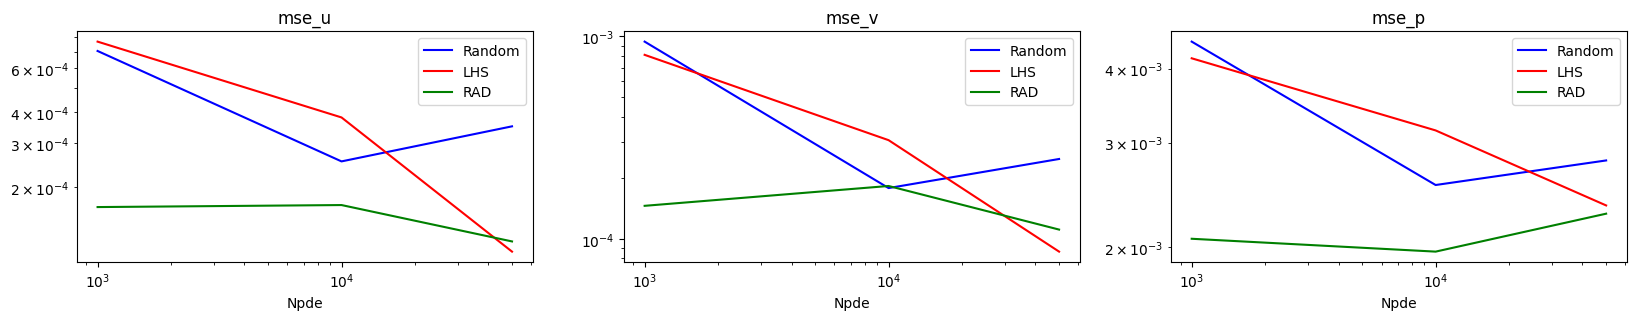

In [90]:
n_datasets
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
for i, title in enumerate(['mse_u', 'mse_v', 'mse_p']):
    ax[i].loglog([n[0] for n in n_datasets], [error[title] for error in rand_mse_error], color='blue', label='Random')
    ax[i].loglog([n[0] for n in n_datasets], [error[title] for error in lhs_mse_error], color='red', label='LHS')
    ax[i].loglog([n[0] for n in n_datasets], [error[title] for error in rad_mse_error], color='green', label='RAD')
    ax[i].set_xlabel('Npde')
    ax[i].set_title(f"{title}")
    ax[i].legend()
plt.show()

### Conclusiones

- Para el último tamaño del dataset se utilizaron 50.000/5.000 muestras por restricciones del hardware disponibles.

- A partir de la gráfica anterior, se observa una mejora apreciable de la norma-2 del error en función del tamaño del dataset para estregias random y LHS pero nó para estrategia RAD.

- La mejor performance de todas se obutvo con la estrategia de muestreo LHS con 50.000/5.000 muestras, aunque la estrategia RAD obtuvo resultados prácticamente similares

- Se observa que para estrategia random y datasets mayores a 10.000/1.000 muestras no se producen mejoras notables del error.

- Al comparar las estrategias entre si, el mejor desempeño para datasets de menor tamaño fue alcanzado por la estrategia RAD. Con datasets de mayor tamaño el error conseguido con otras estrategias comienza a asemejarse al error de la estrategia RAD.

- Las observaciones anteriores eran esperables:
    - El mejor comportamiento con datasets pequeños lo obtuvo la estrategia de RAD ya que elije los puntos críticos en cada actualización del dataset.
    - Se esperaba que las estrategias random y LHS reporten una mejora notable del error con el aumento del tamaño del dataset, mientras que para la estrategia RAD el aumento no fuera tan notable.
    - Finalmente no se esperaba que el mejor error se obtuviese con estrategia LHS, aunque RAD obtuvo resultados prácticamente similares. Se estima que esto se debió a las condiciones aleatorias del experimento específico y no a bondades del método de elección de las muestras.

## TP N° 4: Resolución del problema inverso

### Muestreo ground-truth

In [22]:
n_pde = 10_000
n_bc = 1_000
xy_pde_lhs = get_xy_pde_lhs([x_lb, x_ub], [y_lb, y_ub], n_pde)
X_pde = torch.tensor(xy_pde_lhs, requires_grad = True).float().to(device)
xy_bc_lhs = get_xy_bc_lhs([x_lb, x_ub], [y_lb, y_ub], n_bc)
X_bc = torch.tensor(xy_bc_lhs).float().to(device)
X_bc_0 = torch.tensor([[0, 0]]).float().to(device)
mesh_size_list = [0.25, 0.5, 0.75]
n_mesh_size = 5

xy_data_all = np.concatenate([pressure_raw_data['x'][0][:,np.newaxis], pressure_raw_data['y'][0][:,np.newaxis]], axis=1)
labels_data_all = np.concatenate([velocity_raw_data['u'][0][:,np.newaxis],velocity_raw_data['v'][0][:,np.newaxis],
                                 pressure_raw_data['p'][0][:,np.newaxis]], axis=1)

In [23]:
def get_ds_data_mesh(pressure_ds, velocity_ds, mesh_size, n):
    x_bounds = [0.5 - mesh_size/2, 0.5 + mesh_size/2]
    y_bounds = [0.5 - mesh_size/2, 0.5 + mesh_size/2]
    x = np.linspace(x_bounds[0], x_bounds[1], n)
    y = np.linspace(y_bounds[0], y_bounds[1], n)
    xy = np.array([[x_i,y_i] for x_i in x for y_i in y])
    
    # Not all points are aligned. If a point is missing, we will find the nearest neightbor.
    u_interp_func = LinearNDInterpolator((pressure_ds['x'][0], pressure_ds['y'][0]), velocity_ds['u'][0])
    v_interp_func = LinearNDInterpolator((pressure_ds['x'][0], pressure_ds['y'][0]), velocity_ds['v'][0])
    p_interp_func = LinearNDInterpolator((pressure_ds['x'][0], pressure_ds['y'][0]), pressure_ds['p'][0])
    
    labels = []
    for idx in range(len(xy)):
        data_idx = np.argwhere(np.logical_and(pressure_ds['x'][0] == xy[idx,0], pressure_ds['y'][0] == xy[idx,1]))
        if len(data_idx) > 0:
            data_idx = data_idx[0][0]
            assert pressure_ds['x'][0][data_idx] == velocity_ds['x'][0][data_idx]
            assert pressure_ds['y'][0][data_idx] == velocity_ds['y'][0][data_idx]
            labels.append([velocity_ds['u'][0][data_idx], velocity_ds['v'][0][data_idx], pressure_ds['p'][0][data_idx]])
        else:
            u_interpolated = u_interp_func(xy[idx,:])[0]
            v_interpolated = v_interp_func(xy[idx,:])[0]
            p_interpolated = p_interp_func(xy[idx,:])[0]
            labels.append([u_interpolated, v_interpolated, p_interpolated])
    return xy, np.array(labels)

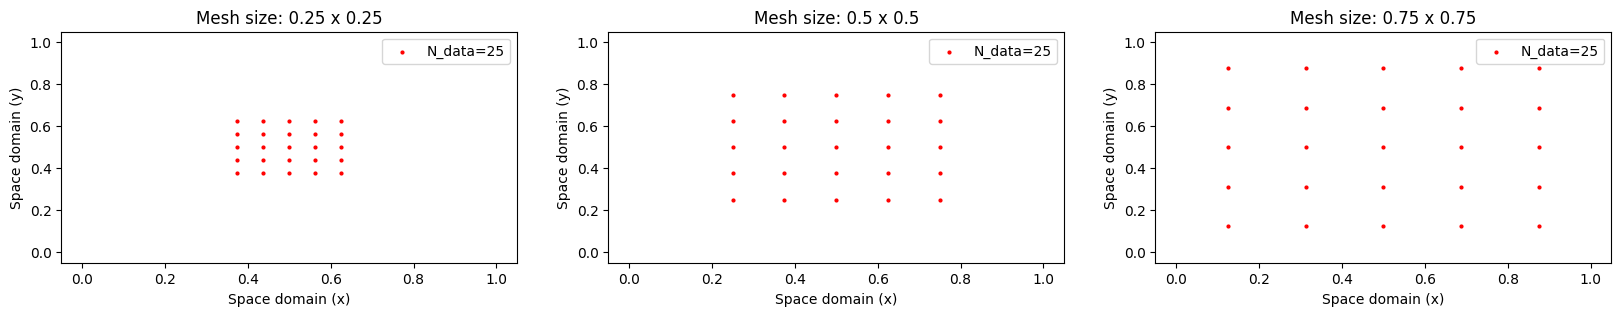

In [24]:
fig, ax = plt.subplots(1, len(mesh_size_list), figsize=(20, 3))
for i, mesh_size in enumerate(mesh_size_list):
    xy_data_mesh, labels_data_mesh = get_ds_data_mesh(pressure_raw_data, velocity_raw_data, mesh_size, 5)
    ax[i].scatter(xy_data_mesh[:,0], xy_data_mesh[:,1], s=4, c='r', label=f'N_data={len(xy_data_mesh)}')
    ax[i].set_xlim([-0.05, 1.05])
    ax[i].set_ylim([-0.05, 1.05])
    ax[i].set_xlabel('Space domain (x)')
    ax[i].set_ylabel('Space domain (y)')
    ax[i].set_title(f"Mesh size: {mesh_size} x {mesh_size}")
    ax[i].legend()
plt.show()

### Datos limpios

In [32]:
# Shared model parameters
abs_smooth_fun = lambda x: x * torch.tanh(1e3 * x)
model_parameters = {
    "Reynolds": 100,
    "InputDimensions": 2,
    "OutputDimensions": 3,
    "NumberOfNeurons": 100,
    "NumberOfHiddenLayers": 4,
    "ActivationFunction": nn.GELU()
}
epochs = 20_000

In [33]:
def train_step(model, loss_fn, X_pde, X_bc, X_bc_0, X_data, Y_data, Re):
    model.Reynolds = abs_smooth_fun(Re)
    # PDE
    output_pde = model(X_pde)
    residue_continuity, residue_momentum_x, residue_momentum_y  = model.pdeResidue(X_pde, output_pde)
    loss_pde_continuity = loss_fn(residue_continuity, torch.zeros_like(residue_continuity))
    loss_pde_momentum_x = loss_fn(residue_momentum_x, torch.zeros_like(residue_momentum_x))
    loss_pde_momentum_y = loss_fn(residue_momentum_y, torch.zeros_like(residue_momentum_y))
    loss_pde = (loss_pde_continuity + loss_pde_momentum_x + loss_pde_momentum_y) / 3
    
    # BC
    output_bc = model(X_bc)
    residue_u, residue_v = model.bcUVResidue(X_bc, output_bc)
    loss_bc_u = loss_fn(residue_u, torch.zeros_like(residue_u))
    loss_bc_v = loss_fn(residue_v, torch.zeros_like(residue_v))
    output_bc_0 = model(X_bc_0)
    residue_p = model.bcPResidue(X_bc_0, output_bc_0)
    loss_bc_p = loss_fn(residue_p, torch.zeros_like(residue_p))
    loss_bc = loss_bc_u * 10 + loss_bc_v * 10 + loss_bc_p * 100
    
    #Loss data
    y_hat_data = model(X_data)
    loss_data = loss_fn(y_hat_data, Y_data)
    
    return loss_pde, loss_bc, loss_data

In [34]:
print("Reynolds parameter inverse problem with clean data")

for mesh_size in mesh_size_list:
    # Init
    model = PINN_Module(model_parameters).to(device)
    reynolds = nn.Parameter(torch.rand(1).to(device))
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam([
        {'params': model.parameters(), 'lr': 1e-3},
        {'params': reynolds, 'lr': 1}])

    xy_data_mesh, labels_data_mesh = get_ds_data_mesh(pressure_raw_data, velocity_raw_data, mesh_size, 5)
    X_data = torch.tensor(xy_data_mesh).float().to(device)
    Y_data = torch.tensor(labels_data_mesh).float().to(device)

    # Train
    print("------------------------------------------------------------")
    print(f"Mesh size: {mesh_size} x {mesh_size}")
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        loss_pde, loss_bc, loss_data = train_step(model, loss_fn, X_pde, X_bc, X_bc_0, X_data, Y_data, reynolds)
        loss_overall = loss_pde + loss_bc + loss_data
        loss_overall.backward()
        optimizer.step()
        if (epoch+1) % (epochs / 20) == 0:
            tqdm.write(f"Epoch {epoch+1}/{epochs} - Loss Overall: {loss_overall.item():.4e}, "
                       f"PDE: {loss_pde.item():.4e}, BC: {loss_bc.item():.4e}, Data: {loss_data.item():.4e} - "
                       f"Reynolds: {abs_smooth_fun(reynolds).item()}")
    print(f"Reynolds value: {abs_smooth_fun(reynolds).item()}")
    # Calculate error
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_all).float().to(device)
        output_data = model(X_data).cpu().numpy()
    mse_u = mean_squared_error(output_data[:,0], labels_data_all[:,0])
    mse_v = mean_squared_error(output_data[:,1], labels_data_all[:,1])
    mse_p = mean_squared_error(output_data[:,2], labels_data_all[:,2])
    print(f"Error on ground-truth mse_u: {mse_u} | mse_v: {mse_v} | mse_p: {mse_p}")

Reynolds parameter inverse problem with clean data
------------------------------------------------------------
Mesh size: 0.25 x 0.25


  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 1000/20000 - Loss Overall: 1.3059e-01, PDE: 1.4986e-02, BC: 1.1122e-01, Data: 4.3844e-03 - Reynolds: 94.6339111328125
Epoch 2000/20000 - Loss Overall: 8.1289e-02, PDE: 9.5917e-03, BC: 6.9857e-02, Data: 1.8401e-03 - Reynolds: 169.91064453125
Epoch 3000/20000 - Loss Overall: 6.4777e-02, PDE: 1.0547e-02, BC: 5.3108e-02, Data: 1.1220e-03 - Reynolds: 250.94094848632812
Epoch 4000/20000 - Loss Overall: 4.9640e-02, PDE: 9.5618e-03, BC: 3.9380e-02, Data: 6.9802e-04 - Reynolds: 325.28912353515625
Epoch 5000/20000 - Loss Overall: 4.1892e-02, PDE: 8.6719e-03, BC: 3.2703e-02, Data: 5.1715e-04 - Reynolds: 403.4864501953125
Epoch 6000/20000 - Loss Overall: 3.5224e-02, PDE: 8.1680e-03, BC: 2.6695e-02, Data: 3.6028e-04 - Reynolds: 490.86358642578125
Epoch 7000/20000 - Loss Overall: 3.0740e-02, PDE: 7.3499e-03, BC: 2.3080e-02, Data: 3.0999e-04 - Reynolds: 592.0830688476562
Epoch 8000/20000 - Loss Overall: 3.0804e-02, PDE: 7.0195e-03, BC: 2.3544e-02, Data: 2.4014e-04 - Reynolds: 709.5288696289062


  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 1000/20000 - Loss Overall: 1.4497e-01, PDE: 1.5786e-02, BC: 1.2368e-01, Data: 5.5074e-03 - Reynolds: 67.13082885742188
Epoch 2000/20000 - Loss Overall: 1.1757e-01, PDE: 1.3775e-02, BC: 1.0106e-01, Data: 2.7281e-03 - Reynolds: 114.31157684326172
Epoch 3000/20000 - Loss Overall: 7.0213e-02, PDE: 1.2383e-02, BC: 5.6396e-02, Data: 1.4348e-03 - Reynolds: 156.91848754882812
Epoch 4000/20000 - Loss Overall: 7.2604e-02, PDE: 1.1693e-02, BC: 6.0170e-02, Data: 7.4118e-04 - Reynolds: 198.5251922607422
Epoch 5000/20000 - Loss Overall: 4.7700e-02, PDE: 1.0482e-02, BC: 3.6563e-02, Data: 6.5541e-04 - Reynolds: 244.46493530273438
Epoch 6000/20000 - Loss Overall: 3.8545e-02, PDE: 8.8672e-03, BC: 2.9171e-02, Data: 5.0660e-04 - Reynolds: 293.56353759765625
Epoch 7000/20000 - Loss Overall: 3.8049e-02, PDE: 7.5539e-03, BC: 3.0047e-02, Data: 4.4778e-04 - Reynolds: 346.8485107421875
Epoch 8000/20000 - Loss Overall: 3.0918e-02, PDE: 7.5876e-03, BC: 2.2849e-02, Data: 4.8159e-04 - Reynolds: 404.6187744140

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 1000/20000 - Loss Overall: 1.5889e-01, PDE: 2.1021e-02, BC: 1.3228e-01, Data: 5.5894e-03 - Reynolds: 36.982662200927734
Epoch 2000/20000 - Loss Overall: 9.3926e-02, PDE: 1.4463e-02, BC: 7.7748e-02, Data: 1.7153e-03 - Reynolds: 55.51778793334961
Epoch 3000/20000 - Loss Overall: 7.1007e-02, PDE: 1.1219e-02, BC: 5.9108e-02, Data: 6.7981e-04 - Reynolds: 70.03773498535156
Epoch 4000/20000 - Loss Overall: 5.4863e-02, PDE: 9.6459e-03, BC: 4.4752e-02, Data: 4.6491e-04 - Reynolds: 82.50106048583984
Epoch 5000/20000 - Loss Overall: 3.7726e-02, PDE: 6.5637e-03, BC: 3.0960e-02, Data: 2.0248e-04 - Reynolds: 94.40902709960938
Epoch 6000/20000 - Loss Overall: 2.9762e-02, PDE: 5.0979e-03, BC: 2.4544e-02, Data: 1.2019e-04 - Reynolds: 108.41265869140625
Epoch 7000/20000 - Loss Overall: 2.7577e-02, PDE: 3.4739e-03, BC: 2.4013e-02, Data: 8.9824e-05 - Reynolds: 121.84196472167969
Epoch 8000/20000 - Loss Overall: 2.1950e-02, PDE: 3.0338e-03, BC: 1.8813e-02, Data: 1.0332e-04 - Reynolds: 133.41354370117

### Datos con ruido

In [35]:
# Noise percentage
omega = 0.01

In [38]:
print("Reynolds parameter inverse problem with noisy data")

for mesh_size in mesh_size_list:
    # Init
    model = PINN_Module(model_parameters).to(device)
    reynolds = nn.Parameter(torch.rand(1).to(device))
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam([
        {'params': model.parameters(), 'lr': 1e-3},
        {'params': reynolds, 'lr': 1}])

    xy_data_mesh, labels_data_mesh = get_ds_data_mesh(pressure_raw_data, velocity_raw_data, mesh_size, 5)
    labels_data_mesh = labels_data_mesh + \
        omega * np.max(labels_data_mesh, axis=0)[np.newaxis,:] * np.random.normal(size=(labels_data_mesh.shape))
    X_data = torch.tensor(xy_data_mesh).float().to(device)
    Y_data = torch.tensor(labels_data_mesh).float().to(device)

    # Train
    print("------------------------------------------------------------")
    print(f"Mesh size: {mesh_size} x {mesh_size}")
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        loss_pde, loss_bc, loss_data = train_step(model, loss_fn, X_pde, X_bc, X_bc_0, X_data, Y_data, reynolds)
        loss_overall = loss_pde + loss_bc + loss_data
        loss_overall.backward()
        optimizer.step()
        if (epoch+1) % (epochs / 20) == 0:
            tqdm.write(f"Epoch {epoch+1}/{epochs} - Loss Overall: {loss_overall.item():.4e}, "
                       f"PDE: {loss_pde.item():.4e}, BC: {loss_bc.item():.4e}, Data: {loss_data.item():.4e} - "
                       f"Reynolds: {abs_smooth_fun(reynolds).item()}")
    print(f"Reynolds value: {abs_smooth_fun(reynolds).item()}")
    # Calculate error
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_all).float().to(device)
        output_data = model(X_data).cpu().numpy()
    mse_u = mean_squared_error(output_data[:,0], labels_data_all[:,0])
    mse_v = mean_squared_error(output_data[:,1], labels_data_all[:,1])
    mse_p = mean_squared_error(output_data[:,2], labels_data_all[:,2])
    print(f"Error on ground-truth mse_u: {mse_u} | mse_v: {mse_v} | mse_p: {mse_p}")

Reynolds parameter inverse problem with noisy data
------------------------------------------------------------
Mesh size: 0.25 x 0.25


  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 1000/20000 - Loss Overall: 1.7729e-01, PDE: 2.0721e-02, BC: 1.5468e-01, Data: 1.8898e-03 - Reynolds: 10.434347152709961
Epoch 2000/20000 - Loss Overall: 1.2938e-01, PDE: 1.9272e-02, BC: 1.0901e-01, Data: 1.0987e-03 - Reynolds: 15.481565475463867
Epoch 3000/20000 - Loss Overall: 9.3794e-02, PDE: 1.5535e-02, BC: 7.7280e-02, Data: 9.7947e-04 - Reynolds: 22.147201538085938
Epoch 4000/20000 - Loss Overall: 6.4251e-02, PDE: 1.1617e-02, BC: 5.2125e-02, Data: 5.0930e-04 - Reynolds: 28.212467193603516
Epoch 5000/20000 - Loss Overall: 4.9286e-02, PDE: 9.2606e-03, BC: 3.9636e-02, Data: 3.9022e-04 - Reynolds: 34.20429611206055
Epoch 6000/20000 - Loss Overall: 4.1645e-02, PDE: 6.6117e-03, BC: 3.4789e-02, Data: 2.4427e-04 - Reynolds: 40.81296157836914
Epoch 7000/20000 - Loss Overall: 3.2993e-02, PDE: 7.6872e-03, BC: 2.5107e-02, Data: 1.9865e-04 - Reynolds: 47.97142791748047
Epoch 8000/20000 - Loss Overall: 2.7352e-02, PDE: 4.5941e-03, BC: 2.2618e-02, Data: 1.3924e-04 - Reynolds: 55.51871490478

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 1000/20000 - Loss Overall: 1.3150e-01, PDE: 2.0021e-02, BC: 1.0878e-01, Data: 2.7025e-03 - Reynolds: 52.44612121582031
Epoch 2000/20000 - Loss Overall: 7.9900e-02, PDE: 1.4783e-02, BC: 6.3850e-02, Data: 1.2669e-03 - Reynolds: 88.81922912597656
Epoch 3000/20000 - Loss Overall: 5.8044e-02, PDE: 1.3058e-02, BC: 4.4329e-02, Data: 6.5685e-04 - Reynolds: 121.39179992675781
Epoch 4000/20000 - Loss Overall: 4.5510e-02, PDE: 1.1652e-02, BC: 3.3468e-02, Data: 3.8983e-04 - Reynolds: 151.96107482910156
Epoch 5000/20000 - Loss Overall: 3.6430e-02, PDE: 9.6061e-03, BC: 2.6451e-02, Data: 3.7247e-04 - Reynolds: 178.58197021484375
Epoch 6000/20000 - Loss Overall: 2.8536e-02, PDE: 7.1106e-03, BC: 2.1164e-02, Data: 2.6154e-04 - Reynolds: 199.24729919433594
Epoch 7000/20000 - Loss Overall: 4.1591e-02, PDE: 8.1214e-03, BC: 3.3090e-02, Data: 3.8025e-04 - Reynolds: 216.42547607421875
Epoch 8000/20000 - Loss Overall: 2.0139e-02, PDE: 4.7729e-03, BC: 1.5152e-02, Data: 2.1406e-04 - Reynolds: 230.359451293

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 1000/20000 - Loss Overall: 1.3185e-01, PDE: 1.4910e-02, BC: 1.0993e-01, Data: 7.0112e-03 - Reynolds: 77.99290466308594
Epoch 2000/20000 - Loss Overall: 9.3722e-02, PDE: 1.3332e-02, BC: 7.5709e-02, Data: 4.6807e-03 - Reynolds: 122.2645263671875
Epoch 3000/20000 - Loss Overall: 7.0461e-02, PDE: 1.3599e-02, BC: 5.2908e-02, Data: 3.9534e-03 - Reynolds: 169.52142333984375
Epoch 4000/20000 - Loss Overall: 6.2447e-02, PDE: 1.4137e-02, BC: 4.5826e-02, Data: 2.4848e-03 - Reynolds: 225.6462860107422
Epoch 5000/20000 - Loss Overall: 5.1180e-02, PDE: 1.3998e-02, BC: 3.5197e-02, Data: 1.9854e-03 - Reynolds: 292.1361389160156
Epoch 6000/20000 - Loss Overall: 4.0118e-02, PDE: 9.9495e-03, BC: 2.8720e-02, Data: 1.4488e-03 - Reynolds: 369.08514404296875
Epoch 7000/20000 - Loss Overall: 4.0620e-02, PDE: 8.5621e-03, BC: 3.0784e-02, Data: 1.2736e-03 - Reynolds: 456.4134521484375
Epoch 8000/20000 - Loss Overall: 3.3674e-02, PDE: 8.0732e-03, BC: 2.4402e-02, Data: 1.1991e-03 - Reynolds: 552.450500488281

### Conclusiones

- De lo observado, en determinados entrenamientos el valor obtenido del número de Reynolds se acercó al valor esperado. Se observa que el entrenamiento es muy sensible a mínimos locales y a las condiciones iniciales de los parámetros de la red, lo que impide que el modelo converga a valores estables.
- Se estima que con una red mas grande y con mayor cantidad de epochs el valor del número de Reynolds se acercaría establemente al valor real.
- Respecto a la distribución espacial de las muestras, se observa que si se toman valores mas separados, el entrenamiento converge más facilmente y a valores de Reynolds mas cercanos al esperado.
- Respecto a la presencia de ruido, se observa que los valores obtenidos poseen mayor error y que la convergencia de la red a los valores de Reynolds esperados es de mayor dificultad.